In [39]:
import sceptre as spt
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")

In [40]:
#load the integrated scMS dataset
dataset = spt.load_dataset(proteins = "process/sceptre_integrated/integrated_Proteins.txt",
                           psms = "process/sceptre_integrated/integrated_PSMs.txt",
                           msms = "process/sceptre_integrated/integrated_MSMSSpectrumInfo.txt",
                           files = "process/sceptre_integrated/integrated_InputFiles.txt",
                           meta = "process/sceptre_integrated/meta.txt")

In [41]:
#print the stats for the single cell channels
s_c_channels = ['128N', '128C', '129N', '129C', '130N', '130C', '131N',
                '131C', '132N', '132C', '133N', '133C', '134N']
spt.print_ms_stats(dataset, s_c_channels=s_c_channels)

Protein IDs: 3044
Peptide IDs: 18576
PSMs: 1005707
PSM rate: 0.286
Median of median S/N in single-cell channels: 6.1
Median of mean S/N in single-cell channels: 9.638
Median S/N of booster channel: 766.4
Mean protein IDs per file: 1222.308


In [42]:
adata = spt.dataset_to_scanpy(dataset,"process/sceptre_result")

In [43]:
# transform meta columns to categories
adata.obs["Column"] = adata.obs["Column"].astype(pd.Int64Dtype()).astype("category")
adata.obs["Plate"] = adata.obs["Plate"].astype(str).astype("category")
# object columns to category
adata.obs.loc[:, adata.obs.dtypes == "object"] = adata.obs.select_dtypes(["object"]
                                                                          ).apply(lambda x: x.astype("category"))
# order some columns
adata.obs["File ID"] = adata.obs["File ID"].cat.reorder_categories(adata.obs["File ID"].unique(), ordered=True)
adata.obs["Channel"] = adata.obs["Channel"].cat.reorder_categories(adata.obs["Channel"].unique(), ordered=True)

# normalize facs parameter between 0 and 1
fasc_params = ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'APC-Cy7-A', 'PE-A']
adata.obs[fasc_params] = adata.obs[fasc_params].apply(lambda x: (x-x.min())/(x-x.min()).max())
# rename the facs parameter
adata.obs = adata.obs.rename(columns={'APC-Cy7-A': 'CD34 APC-Cy7-A', 'PE-A': 'CD38 PE-A'})

# set colors for gated and sorted populations
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
adata.uns['Sorted Population_colors'] = [cols[0], cols[1], cols[2]]
adata.uns['Gated Population_colors'] = [cols[3], cols[0], cols[1], cols[2]]

# failed rows on the plate
adata = adata[~adata.obs['Row'].isin(['I', 'J'])].copy() 

# remove non-single-cell channels
adata = adata[adata.obs['Channel'] != '126'].copy()
adata = adata[adata.obs['Channel'] != '127C'].copy()

performed 100 iterations
6555 values below 1.1 were set to 0
filtered out 19 genes that are detected in less than 1 cells
216 of 2961 cells do not pass filter
removed 216 cells
filtered out 87 genes that are detected in less than 3 cells


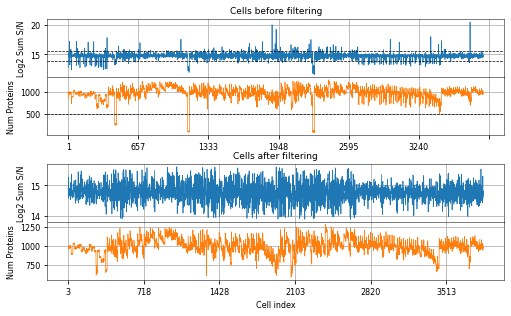

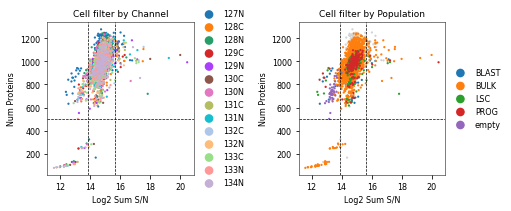

In [44]:
#normalize the datast and quality control
spt.normalize(adata)
spt.calculate_cell_filter(adata)
spt.apply_cell_filter(adata)

In [45]:
# median shift of total intensity across cells
sc.pp.normalize_total(adata, exclude_highly_expressed=True) 
# log2(x+1) transformation
sc.pp.log1p(adata, base=2)
# save the normalized and log2 transformed data as raw data for differential expression testing
adata.raw = adata

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['KRT9', 'KRT1', 'MPO', 'KRT2', 'KRT10', 'KRT5', 'VIM', 'S100A8', 'NME1-NME2; NME1; NME2', 'CTSG', 'S100A9', 'LYZ', 'PRTN3', 'KRT31', 'DCD', 'CCDC158']
    finished (0:00:00)


In [46]:
#load the 24 surface genes' abundance from the cTPnet analysis
blast_marker=pd.read_csv("process/blastCell.marker.txt")
prog_marker=pd.read_csv("process/progCell.marker.txt")

In [47]:
#subset for the overlapping markers
genes=adata.var.index.tolist()
markers=blast_marker.columns.tolist()
markers = [value for value in markers if value in genes]

blast_marker=blast_marker.loc[:,markers]
prog_marker=prog_marker.loc[:,markers]

#append average scMS values
blast_marker.loc[len(blast_marker.index)] = adata[adata.obs["Sorted Population"] == "BLAST",markers].X.mean(0).tolist()
prog_marker.loc[len(prog_marker.index)] = adata[adata.obs["Sorted Population"] == "PROG",markers].X.mean(0).tolist()

Text(0.5, 1.0, 'Progenitor Cells')

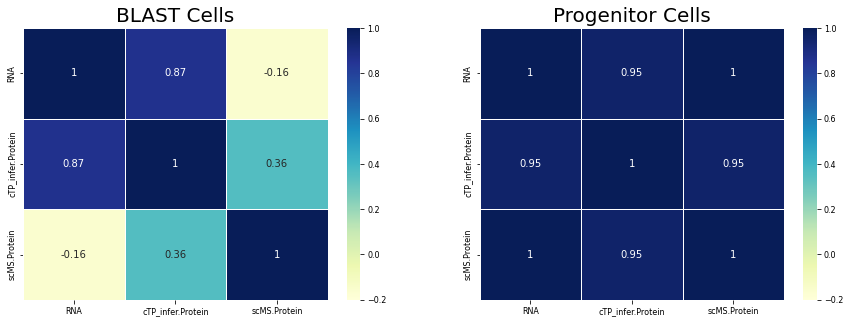

In [48]:
#calculate the correlation and generate heatmaps
idx= ["RNA","cTP_infer.Protein","scMS.Protein"]
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))

#blast cells
corr = np.corrcoef(blast_marker)
df = pd.DataFrame(corr, index=idx,columns=idx)
sns.heatmap(df,ax=axes[0], cmap='YlGnBu', linewidths=1,vmax=1,vmin=-0.2, annot=True)
axes[0].set_title('BLAST Cells',fontsize=20)

#progenitor cells
corr = np.corrcoef(prog_marker)
df = pd.DataFrame(corr, index=idx,columns=idx)
sns.heatmap(df,ax=axes[1], cmap='YlGnBu', linewidths=1,vmax=1,vmin=-0.2, annot=True)
axes[1].set_title('Progenitor Cells',fontsize=20)